In [ ]:
## Main SWR detection analysis! Note there are two ways to analyze the data: a cluster and local version. I keep them
## both updated with changes for now since I tend to check with the local version even if the cluster version is better
## for bulk analysis 2020-6-17 JS
## Updated for catFR1 analysis 2020-09-29 JS. Largely edited for manually removing bad electrodes 
## (search for catFR1 in CLUSTER get for example)

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

import seaborn as sb

df = get_data_index("r1") # all RAM subjects
exp = 'catFR1' # 'FR1' 'catFR1'


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# sub lists I've been using to explore FR1 

subs = ['R1564J'] #'R1385E'] # ['R1065J'] #
# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus

# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
# subs = ['R1010J','R1112M'] # original 2 # R1108J beatiful catFR1 data; R1065J magical subject (like with FR1)
# subs = ['R1112M','R1163T'] # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1368T','R1461T','R1463E'] # subs with particularly low localization.pair matches in pairs...see Excel in loading info on Box for details
# subs = ['R1433E','R1355T','R1367D','R1368T'] # subs with "ca3" or "dg"
# subs = ['R1001P'] # subject with over 8000 FR1 trials X electrodes
# bad_subs = ['R1433E','R1051J'] # no electrode cats
# subs = ['R1379E','R1385E','R1387E','R1394E','R1402E'] # partial beep subs
# subs = ['R1379E','R1402E','R1396T','R1395M','R1415T','R1389J','R1404E']  # test subs for eeg offset correction

subs = ['R1054J','R1345D','R1048E','R1328E','R1308T', # first 2 are sr ≥ 1000. 3rd is 500 Hz.
        'R1137E','R1136N','R1122E','R1385E', # nice example FR1 subs used in Fig. 2
        'R1405E','R1486J','R1501J'] # adding in 3 catFR only patients that will go into Fig. 4
subs = ['R1086M']

# subs = ['R1120E','R1349T','R1397D','R1332M','R1299T'] # FR1 patients with electrode search ranges limited per SWR problem sessions doc on Box
# subs = ['R1269E','R1328E','R1367D','R1397D','R1405E','R1405E','R1447M','R1469D'] # catFR1 patients with electrode search changes limited
# subs = ['R1094T']

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[0:1]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
510,NaN,protocols/r1/subjects/R1086M/experiments/catFR...,protocols/r1/subjects/R1086M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1086M/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1086M/localizations/0/m...,NaN,0,R1086M,R1086M,NaN,protocols/r1/subjects/R1086M/experiments/catFR...


In [3]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
elif exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
                    ]
elif exp == 'RepFR1':
    exp_df = exp_df[
                    (df.subject!='R1564J') # clearly something wrong with these EEG when looking at ripple raster
                    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[-19:]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(568, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
24,NaN,protocols/r1/subjects/R1004D/experiments/catFR...,protocols/r1/subjects/R1004D/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1004D/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1004D/localizations/0/m...,NaN,0,R1004D,R1004D,NaN,protocols/r1/subjects/R1004D/experiments/catFR...
45,NaN,protocols/r1/subjects/R1013E/experiments/catFR...,protocols/r1/subjects/R1013E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1013E/experiments/catFR...,1,NaN,0,protocols/r1/subjects/R1013E/localizations/0/m...,NaN,0,R1013E,R1013E_1,NaN,protocols/r1/subjects/R1013E/experiments/catFR...
58,NaN,protocols/r1/subjects/R1015J/experiments/catFR...,protocols/r1/subjects/R1015J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1015J/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1015J/localizations/0/m...,NaN,0,R1015J,R1015J,NaN,protocols/r1/subjects/R1015J/experiments/catFR...
64,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,0,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
65,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,1,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,1,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,NaN,protocols/r1/subjects/R1662S/experiments/catFR...,protocols/r1/subjects/R1662S/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1662S/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1662S/localizations/0/m...,NaN,7,R1662S,R1662S,3.4,protocols/r1/subjects/R1662S/experiments/catFR...
2846,NaN,protocols/r1/subjects/R1662S/experiments/catFR...,protocols/r1/subjects/R1662S/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1662S/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1662S/localizations/0/m...,NaN,8,R1662S,R1662S,3.4,protocols/r1/subjects/R1662S/experiments/catFR...
2851,NaN,protocols/r1/subjects/R1665J/experiments/catFR...,protocols/r1/subjects/R1665J/localizations/0/m...,catFR1,build,0,NaN,0,NaN,NaN,protocols/r1/subjects/R1665J/localizations/0/m...,NaN,0,R1665J,R1665J,4.0,protocols/r1/subjects/R1665J/experiments/catFR...
2852,NaN,protocols/r1/subjects/R1665J/experiments/catFR...,protocols/r1/subjects/R1665J/localizations/0/m...,catFR1,build,0,NaN,0,NaN,NaN,protocols/r1/subjects/R1665J/localizations/0/m...,NaN,1,R1665J,R1665J,4.0,protocols/r1/subjects/R1665J/experiments/catFR...


## Load CLUSTER data

In [4]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)

selected_period = 'encoding'
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
# 'encoding': aligned to word_on

recall_type_switch = 0

recall_minimum = 2000 # 2000 is default
region_name = 'HPC' #'ENT' #'HPC' #ENT #HPC # PHC # AMY #ENTPHC # nonHPC_MTL
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/hamming125200/tried hamming140250 for math
sub_selection = 'second_half' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
###
%autoreload
# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []; session_events = pd.DataFrame()

electrode_labels = []; channel_coords = []; channel_nums = []

analysis_df = getSplitDF(exp_df,sub_selection,exp)

for row in analysis_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  #analysis_df.itertuples(): 
    try:
        sub = row.subject; session = row.session; exp = row.experiment

        path_name = '/scratch/john/SWR_scratch/'+subfolder
        
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            
#             # specific to whole_encoding
#             if selected_period == 'encoding':
            session_events = session_events.append(dat['session_events']) # doesn't append in place 

            serialpos_array.extend(dat['serialpos_array'])
            recall_position_array.extend(dat['recall_position_array'])   
            list_recall_num_array.extend(dat['list_recall_num_array'])
            
            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
            channel_nums.extend(dat['channel_nums'])
            list_num_key.extend(dat['list_num_key'])
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)
session_events['channel_num'] = channel_nums_array # append channels into the df

# spread out encoded_word_key too so I know which words were correct
word_correct_array = []
for sess_elec in encoded_word_key_array:
    word_correct_array.append(sess_elec)
word_correct_array = np.array(word_correct_array)
word_correct_array[word_correct_array>0] = 1 # 1s and 2s are corrects

# temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
    
# subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
# session_name_array = np.array(session_name_array)[temp_recall_idxs]
# electrode_array = np.array(electrode_array)[temp_recall_idxs]
# channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
# channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
# ripple_array = np.array(ripple_array)[temp_recall_idxs]
# rectime_array = np.array(rectime_array)[temp_recall_idxs]
# list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
# recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
    
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total trials: '+str(int(np.sum(trial_nums))))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')

# some info about regions 
sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))

print('Electrode regions X sessions:')
unique_names = np.unique(HPC_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)
    

['R1393T' 'R1461T' 'R1426N' 'R1269E' 'R1334T' 'R1239E' 'R1217T' 'R1303E'
 'R1264P' 'R1377M']
['R1386T' 'R1493T' 'R1278E' 'R1501J' 'R1477J' 'R1449T' 'R1243T' 'R1293P'
 'R1459M' 'R1496T']
2023-03-21_16-41-15: DF Exception: Sub: R1004D, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/ENCODING/SWR_catFR1_R1004D_0_HPC_encoding_soz_in_hamming.p', file: <ipython-input-4-f1f9e67eec35>, line no: 52
2023-03-21_16-41-16: DF Exception: Sub: R1067P, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/ENCODING/SWR_catFR1_R1067P_1_HPC_encoding_soz_in_hamming.p', file: <ipython-input-4-f1f9e67eec35>, line no: 52
2023-03-21_16-41-20: DF Exception: Sub: R1190P, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/ENCODING/SWR_catFR1_R1190P_0_HPC_encoding_soz_in_hamming.p', file: <ipython-input-4-f1f9e67eec35>, line no: 52
2023-03-21_16-41-27: DF Exception: Sub: R1372C, Sess: 0, File

(155420, 1500)

From 157/163 sessions with >0 HPC electrodes
Total trials: 155420
Unique sessions: 157
...from 80 patients
Number of electrodes: 397
Electrode regions X sessions:
156 for  left hippocampus
141 for  right hippocampus
206 for "ca1"
98 for "dg"
24 for "sub"
59 for left ca1
2 for left ca2
2 for left ca3
29 for left dg
187 for left hippocampus
23 for left sub
77 for right ca1
15 for right dg
144 for right hippocampus
11 for right sub


In [29]:
# to get total patient count including all regions
# HPC_subs = np.unique(subject_name_array)
# AMY_subs = np.unique(subject_name_array)
# ENTPHC_subs = np.unique(subject_name_array)
# test = np.append(np.append(HPC_subs,AMY_subs),ENTPHC_subs)
# np.unique(test)
# len(np.unique(test))

array(['R1015J', 'R1024E', 'R1032D', 'R1035M', 'R1045E', 'R1061T',
       'R1065J', 'R1066P', 'R1067P', 'R1083J', 'R1086M', 'R1089P',
       'R1102P', 'R1105E', 'R1108J', 'R1112M', 'R1131M', 'R1138T',
       'R1144E', 'R1157C', 'R1158T', 'R1167M', 'R1171M', 'R1174T',
       'R1176M', 'R1180C', 'R1188C', 'R1190P', 'R1204T', 'R1207J',
       'R1217T', 'R1221P', 'R1227T', 'R1230J', 'R1236J', 'R1239E',
       'R1243T', 'R1245E', 'R1254E', 'R1264P', 'R1269E', 'R1275D',
       'R1278E', 'R1291M', 'R1293P', 'R1303E', 'R1310J', 'R1313J',
       'R1315T', 'R1320D', 'R1328E', 'R1330D', 'R1332M', 'R1334T',
       'R1337E', 'R1338T', 'R1343J', 'R1347D', 'R1348J', 'R1354E',
       'R1361C', 'R1366J', 'R1367D', 'R1368T', 'R1372C', 'R1374T',
       'R1377M', 'R1379E', 'R1380D', 'R1381T', 'R1382T', 'R1383J',
       'R1385E', 'R1386T', 'R1387E', 'R1388T', 'R1393T', 'R1395M',
       'R1396T', 'R1397D', 'R1398J', 'R1404E', 'R1405E', 'R1413D',
       'R1414E', 'R1415T', 'R1421M', 'R1422T', 'R1423E', 'R142

124

In [60]:
# these should all be the same length!
len(ripple_array)
len(electrode_array)
len(list_num_key)
len(word_correct_array)
len(recall_position_array)
len(serialpos_array)
len(encoded_word_key_array)
len(session_name_array)

241266

97449

97449

97449

97449

97449

97449

97449

(155420, 1500)


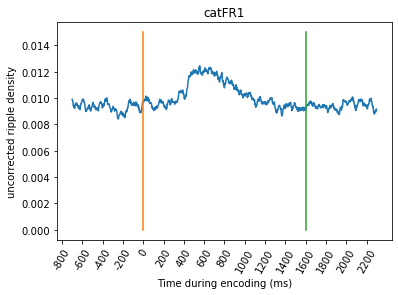

In [69]:
print(np.shape(ripple_array))
plot(np.mean(ripple_array,0))
if selected_period == 'whole_encoding':
    xticks(range(0,20000,2500),range(0,40000,5000))
    plot([1000,1000],[0,0.015])    
elif selected_period == 'encoding':
    xticks(ticks=range(-350,1501,100),labels=range(-1400,3001,200),rotation=60)
    plot([350,350],[0,0.015])
    plot([1150,1150],[0,0.015])   
elif selected_period == 'whole_retrieval':
    xticks(ticks=range(0,17001,2500),labels=range(0,32001,5000),rotation=60)
    plot([1000,1000],[0,0.015]) 
    plot([1000+15000,1000+15000],[0,0.015]) 
# ylim(0,0.015)
title(exp)
ylabel('uncorrected ripple density')
xlabel('Time during encoding (ms)');

## Get start_array and select subfield if HPC for free recalls

In [5]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = True   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to False for anywhere not in HPC like ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected = 'ca1' #['ca1','dg'] #'dg' #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
if filter_type.find('hamming') != -1:
    desired_sample_rate = 500.
else:
    desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array); print('Got encoding start_array!')
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# DON'T USE temp_recall_idxs FOR ENCODING
# # gotta translate this to new frame as well from idxs in load step if selected subfield
# if select_subfield == True: 
#     location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2

# this one list did not have 27 word presentations, so remove it
if exp == 'RepFR1':
    updated_recalls[(np.array(session_name_array)=='R1579T-1') & (np.array(list_num_key)==16)] = 0
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
channel_nums_array = np.array(channel_nums_array)[updated_recalls]
if selected_period in ['surrounding_recall','math','math_retrieval','whole_encoding','whole_retrieval']:
    list_recall_num_array = np.array(list_recall_num_array)[updated_recalls] # for subject-level analysis
# rectime_array = np.array(rectime_array)[updated_recalls]

# specific to encoding

# list_recall_num_array = np.array(list_recall_num_array)[updated_recalls]

# if selected_period in ['encoding','whole_encoding']:
encoded_word_key_array = np.array(encoded_word_key_array)[updated_recalls]
serialpos_array = np.array(serialpos_array)[updated_recalls]
list_num_key = np.array(list_num_key)[updated_recalls]
word_correct_array = word_correct_array[updated_recalls]
recall_position_array = np.array(recall_position_array)[updated_recalls]
# if selected_period == 'encoding':    
#     session_events = session_events[updated_recalls]
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')

sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')
print('...from '+str(len(np.unique(session_name_array)))+' sessions')
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

print('# of trials: '+str(np.shape(start_array)[0]))
print('Total # of ripples: '+str(sum(start_array)))
print('Overall ripple rate: '+str(np.round( (1000/sr_factor)*sum(start_array)/np.shape(start_array)[0]/np.shape(start_array)[1],3 ))+' Hz')

Total electrodes loaded: 877
from 157 sessions from 80 subjects with trial nums:
[300. 300. 156. 156. 156. 156. 156. 156. 156. 156. 216. 216. 216. 216.
 216. 216. 216. 216. 300. 300.]
Trial sum = 155420.0
['left ca3', 'left ca1', 'left ca1', 'left sub', 'left sub', 'left ca1', 'right ca1', 'right ca1', 'right ca1', 'right ca1', 'left ca1', 'left sub', 'left sub', 'left ca1', 'right ca1', 'right ca1', 'right ca1', 'right ca1', 'left ca1', 'left ca1']
Number of sub_sess names: 877
Got encoding start_array!
Got start_array with 65288 trials!
Number of electrodes: 153
...from 56 patients
...from 104 sessions
# of trials: 65288
Total # of ripples: 65583
Overall ripple rate: 0.335 Hz


# Subject-level memory performance

In [50]:
# do subjects show a bigger ripple bump when they remember more words/list?

## NOTE: to run this make sure:
## 1) recall_select_type = 6. HAVE to remove first recalls of each list or will bias result since
##    first recall doesn't have bump anyway and worse performing patients will have more first recalls.
##    selecting for ≥2 recalls takes all trials that should have bumps and compares those
## 2) selected_recalls from last cell gives all trials (it'll crash otherwise due to indexing error)
## 3) for high v. low memory analysis, need to comment out bin_model2, 

# goal is ot measure z-scores of each individual subject and also correlate those to temporal clustering

ripple_bin_start_end = [100,1700]
min_trials = 20 # define up here since use for ME model arrays being appended too

psth_start = -700 # setting in SWRanalysis for pre_encoding_time

import statsmodels.formula.api as smf
import warnings
%autoreload

sub_Ts1 = []
sub_Bs1 = [] 
sub_delta1 = [] # change in ripple rate for recalled - not recalled

# for mixed model of correlations get session-level ripples and accuracy
sess_sessions = []
sess_delta = []
sess_subjects = []
sess_recall_num = []

trial_accum = []; trial_accum_correct = []
sub_z_score = []
rate_accum = []; rate_accum_correct = []; rate_accum_wrong = []
trial_ct = 0
temp_sub_names = []
sub_avg_recall_num = []; sub_avg_recall_time = []

# all these ME variables are at trial-level
ME_bin = []; ME_subject_recall_num = []
ME_sessions = []; ME_subjects = []
ME_list_level_correct = []; ME_correct = []
ME_delta = []


for sub in np.unique(subject_name_array):
    sub_idxs = [sub in s for s in subject_name_array]
    if sum(sub_idxs) > 1:
        sub_start_array = start_array[sub_idxs]
        sub_subject_name_array = subject_name_array[sub_idxs]
        sub_session_name_array = session_name_array[sub_idxs]        
        sub_electrode_array = electrode_array[sub_idxs]
        sub_recall_position_array = recall_position_array[sub_idxs]
        sub_word_correct_array = word_correct_array[sub_idxs]        
        sub_list_num_key = list_num_key[sub_idxs]
       
        # now get z-score separately for each sub with ME model

        # measure significance from 
        stats_bin = ripple_bin_start_end[1]-ripple_bin_start_end[0] # only using 1 bin for encoding        
        binned_stats_array = sub_start_array[:,int((ripple_bin_start_end[0]-psth_start)/sr_factor):
                                               int((ripple_bin_start_end[1]-psth_start)/sr_factor)]
        binned_stats_array = binBinaryArray(binned_stats_array,stats_bin,sr_factor)
        
        if len(binned_stats_array) >= min_trials:
            
            # what is this patient's average accuracy?
            session_avg_corr = []
            for i_sess,sess in enumerate(np.unique(sub_session_name_array)):
                
                # take single elec from every session so don't double count sessions

                first_elec = np.unique(sub_electrode_array[sub_session_name_array==sess])[0]
                
                session_recalls = sub_recall_position_array[((sub_session_name_array==sess) & \
                                                         (sub_electrode_array==first_elec))]# this is a list of lists for accuracy in this session
                sub_list_level_recalls = [len(np.unique(np.array(x)[np.array(x)>0])) for x in session_recalls]
                if len(sub_list_level_recalls)==0:
                    print('First session does not have first electrode for '+sess)
                session_avg_corr.append(np.nanmean(sub_list_level_recalls)) # mean correct for this session (lists always same length so can just avg)
                
                # but to know list-level accuracy for each trial we need to do this for every electrode
                for elec in np.unique(sub_electrode_array):
                    session_recalls = sub_recall_position_array[((sub_session_name_array==sess) & \
                                                                 (sub_electrode_array==elec))]
                    ME_list_level_correct.extend([len(np.unique(np.array(x)[np.array(x)>0])) for x in session_recalls])
                    
                # session-level info for ME model across subs
                sess_subjects.append(sub)
                sess_sessions.append(sess)
                sess_recall_num.append(np.nanmean(sub_list_level_recalls))
                # session-level ripple delta
                sess_delta.append(np.mean(binned_stats_array[((sub_session_name_array==sess) & (sub_word_correct_array==1))]) - 
                                np.mean(binned_stats_array[((sub_session_name_array==sess) & (sub_word_correct_array==0))]))
                    

            sub_avg_recall_num.append(np.nanmean(session_avg_corr)) # average over sessions for final accuracy value
            temp_sub_names.append(sub)

            rate_accum.append(np.mean(binned_stats_array))
            rate_accum_correct.append(np.mean(binned_stats_array[sub_word_correct_array==1]))
            rate_accum_wrong.append(np.mean(binned_stats_array[sub_word_correct_array==0]))            
            trial_accum.append(len(binned_stats_array))
            trial_accum_correct.append(sum(sub_word_correct_array))
            trial_ct+=len(binned_stats_array)
            

            

            if np.mod(len(temp_sub_names),10)==0:
                print('done binning start_arrays (printing every 10th)'); len(binned_stats_array)
                print(str(np.mean(binned_stats_array))+' for '+str(len(binned_stats_array))+ ' trials')
                print(trial_ct)

            # create data arrays for mixed effects model (all of these are at trial-level)

            ME_bin.extend([r[0] for r in binned_stats_array]) # need to unpack each array
            ME_subject_recall_num.extend(sub_avg_recall_num[-1]*np.ones(len(binned_stats_array)))
            ME_correct.extend(sub_word_correct_array)
            ME_sessions.extend(sub_session_name_array)
            ME_subjects.extend(sub_subject_name_array)
            ME_delta.extend( (rate_accum_correct[-1]-rate_accum_wrong[-1]) * np.ones(len(binned_stats_array)) ) 

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                
                # model for each sub to assess significance of SME
                sub_SME_df = pd.DataFrame(data={'session':sub_session_name_array,'subject':sub_subject_name_array,
                               'correct':sub_word_correct_array,'ripple_rates':binned_stats_array[:,0]})
                vc = {'session':'0+session'}
                sig_bin_model = smf.mixedlm("ripple_rates ~ correct", sub_SME_df, groups="subject", vc_formula=vc,re_formula='correct')
                bin_model = sig_bin_model.fit(reml=True, method='nm',maxiter=2000)

                sub_Ts1.append(bin_model.tvalues[1])
                sub_Bs1.append(bin_model.params[1])
                
# corrected_for_nans = 0 # for below
a=1;

done binning start_arrays (printing every 10th)
0.3614583333333333 for 2400 trials
10068
done binning start_arrays (printing every 10th)
0.12708333333333333 for 600 trials
17184
done binning start_arrays (printing every 10th)
0.0998263888888889 for 144 trials
20832
done binning start_arrays (printing every 10th)
0.150089605734767 for 1116 trials
29160
done binning start_arrays (printing every 10th)
0.17447916666666666 for 240 trials
35280


In [51]:
# run this to select good subs for figures below (can only run once after load since it replaces variables)

import seaborn as sb
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
    
def defaultPlotting(): 
    sb.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

if location_selected == 'dg':
    min_rate = 0.1
    plot_color = [(0.8,0,0)]
    lmplot_color = (0.8,0,0,0)
    errorbar_color = (1,0.5,0.5)
    line_color = 'darkred'
elif region_name == 'ENT':
    min_rate = 0.0 # for ENT and PHC I don't do further stats so just set to 0 to show all the datapoints in the swarm
    plot_color = [(0.5,0.5,0)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0.8,0.8,0)
    line_color = 'black'
elif region_name == 'PHC':
    min_rate = 0.0
    plot_color = [(0,0.5,0.5)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0,0.8,0.8)
    line_color = 'black' 
elif location_selected == 'ca1' or location_selected == '':
    min_rate = 0.1 # for CA1 and DG I require a FR minimum for the two bins being compared since I do further stats on them
    plot_color = [(0,0,0.8)]
    lmplot_color = (0,0,0.8,0)
    errorbar_color = (0.5,0.5,1)
    line_color = 'darkblue'
    
min_correct_trials = 50

# only keep subs with sufficient trials and ripple rates
good_subs = ((np.array(trial_accum_correct)>=min_correct_trials)&(np.array(rate_accum) > min_rate))
rate_accum = np.array(rate_accum)[good_subs]  
rate_accum_correct = np.array(rate_accum_correct)[good_subs]
rate_accum_wrong = np.array(rate_accum_wrong)[good_subs]
sub_Ts1 = np.array(sub_Ts1)[good_subs]    
trial_accum = np.array(trial_accum)[good_subs]    
temp_sub_names = np.array(temp_sub_names)[good_subs]        
sub_avg_recall_num = np.array(sub_avg_recall_num)[good_subs]  

Mixed model of *delta* ripple_rate ~ avg_recall_num at session-level
                 Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   delta_ripple_rate
No. Observations:     96        Method:               REML             
No. Groups:           52        Scale:                0.0000           
Min. group size:      1         Likelihood:           96.2984          
Max. group size:      6         Converged:            Yes              
Mean group size:      1.8                                              
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    -0.021    0.019 -1.109 0.267 -0.059  0.016
avg_recall_num                0.002    0.005  0.362 0.717 -0.007  0.011
subject Var                   0.000  893.737                           
subject x av

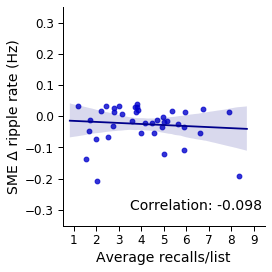

In [53]:
### subject-level figures we decided on ###

save_figs = 0

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    # this really just assesses recalls vs. ripple rate
#     ME_df = pd.DataFrame({'ripple_rate':ME_bin,'avg_recall_num':ME_subject_recall_num,'delta_ripple_rate':ME_delta,
#                             'session':ME_sessions,'subject':ME_subjects,'correct':ME_correct})      
    
#     print('Mixed model of ripple_rate ~ avg_recall_num')
#     vc = {'session':'0+session'}
#     sig_bin_model = smf.mixedlm("ripple_rate ~ avg_recall_num", ME_df, groups="subject", vc_formula=vc,re_formula="avg_recall_num")
#     bin_model1 = sig_bin_model.fit(reml=True, method='nm',maxiter=2000) 
#     print(bin_model1.summary())

    # mixed model of correlation below (this is session-level)
    sess_df = pd.DataFrame({'delta_ripple_rate':sess_delta,'avg_recall_num':sess_recall_num,
                            'session':sess_sessions,'subject':sess_subjects})
    print('Mixed model of *delta* ripple_rate ~ avg_recall_num at session-level')         
    vc = {'session':'0+session'}
    sig_bin_model = smf.mixedlm("delta_ripple_rate ~ avg_recall_num", sess_df, groups="subject", vc_formula=vc,re_formula="avg_recall_num")
    bin_model1 = sig_bin_model.fit(reml=True, method='nm',maxiter=2000) 
    print(bin_model1.summary())
    
    
## Ripple rate delta v. recall num ##

rate_accum_delta = np.array(rate_accum_correct) - np.array(rate_accum_wrong)

set_pubfig()
deltaRR_df = pd.DataFrame({'avg_recall_num':sub_avg_recall_num,'ripple_rates':rate_accum_delta,
                        'sub_Ts1':sub_Ts1})
fig, ax = subplots(figsize=(4,4))
sb.regplot(ax=ax,x='avg_recall_num',y='ripple_rates',data=deltaRR_df,
         scatter_kws = {'color': lmplot_color},line_kws = {'color': line_color})

if exp == 'FR1':
    gca().set(ylim=(-0.31,0.31),xlim=(0.5,7.5))
    xticks(np.arange(1,7.5+0.01,1))
elif exp == 'catFR1':
    gca().set(ylim=(-0.35,0.35),xlim=(0.5,9.5))
    xticks(np.arange(1,9.5+0.01,1))
gca().tick_params(labelsize=12)

plot_corr = stats.pearsonr(sub_avg_recall_num,rate_accum_delta)

annotate('Correlation: '+str(np.round(plot_corr[0],3)),(3.5,-0.3)) 
# annotate('p-values: '+str(np.round(plot_corr[1],3)),(3.5,-0.29)) # use mixed model p-value instead:
# annotate('$\it{P}$-value: '+str(np.round(bin_model1.pvalues[1]
#                                    ,3)),(3.5,-0.29))

ylabel(u'SME Δ ripple rate (Hz)')
xlabel('Average recalls/list')
if type(location_selected)==list:
    location_selected = location_selected[0]+location_selected[1]
# title('Encoding ripple rise v. accuracy ('+location_selected.upper()+')')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
tight_layout()
if save_figs == 1:
    fname = '/home1/john/SWR/figures/subject-level_plots/deltaRRvMemory_'+exp+'_'+region_name+'_'+\
        location_selected+'_encoding_'+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)

show()





# ##$$$ ###

a=1;

## Big Raster!!

(35040, 1500)


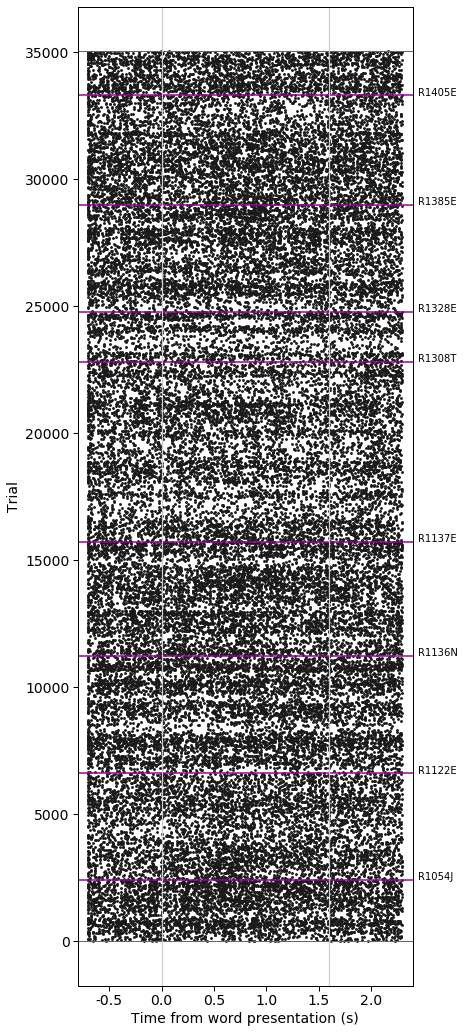

In [164]:

## for the raster and PSTH binarize the data by using the start indices of the ripple

save_raster = 0

%autoreload

elec_dividers_on = 0 # toggles gray lines between electrodes
session_dividers_on = 0 # toggles cyan lines between sessions

dot_color = (0.1,0.1,0.1)
between_subject_color = (0.6,0,0.6) # purple
between_session_color = (0,0.6,0.6) # cyan

# encoding_whole_time = 1000*np.round(12*(1.6+0.875),1)

if selected_period == 'encoding':
    psth_start = -700
    psth_end = 2300
elif selected_period == 'whole_encoding':
    psth_start = -2000
    psth_end = encoding_whole_time #2000
    
raster_width = 6
raster_height = 18 #0 #10 # 40

# plot raster
subplots(1,1,figsize=(raster_width,raster_height))   #y=100 for data cleaning # (4,6) for Fig. 4b # (4,10) for Fig. 2a
scatter(np.where(start_array)[1]*sr_factor+psth_start,np.where(start_array)[0],s=4,color=dot_color) # SWR time v. trial
# xticks(np.arange(psth_start,psth_end+1,500),np.round(np.arange(psth_start/1000,psth_end/1000+1,0.5),2))
xticks(np.arange(-500,2001,500),np.arange(-0.5,2.01,0.5),size=14)
yticks(size=14)
xlabel('Time from word presentation (s)',size=14)
ylabel('Trial')
ax = plt.gca()
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))

last_sub = sub_names[0]
last_sess = sub_sess_names[0]
channels_per_session = []
trial_accum = 0
for s in range(1,len(trial_nums)):
    if (sub_names[s] != last_sub) | (s==1):
        if s != 1:
            # plot dark gray line between subjects
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=1.5,linestyle='-',color=between_subject_color)
            last_sub = sub_names[s]
            text(psth_end+150,0.5+np.sum(trial_nums[:s]),sub_names[s])
        else: 
            if session_dividers_on==1:
                # if 1st sub though gotta print that first gray line 
                plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=between_session_color)
                text(psth_end+100,0,sub_names[s]) # and print 1st sub name at y=0
    else: # plot lines between electrodes
        if elec_dividers_on == 1:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=(.8,.8,.8))
    # plot lines between sessions
    if session_dividers_on==1:
        if sub_sess_names[s] != last_sess:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.75,linestyle='-',color=between_session_color)
            last_sess = sub_sess_names[s]
            
    channels_per_session.append(np.unique(channel_nums_array[int(trial_accum):int(trial_accum+trial_nums[s])]))
    trial_accum = trial_accum+trial_nums[s]
    
plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
gca().axvline(0, ls='-',color=(0.8,0.8,0.8))
gca().axvline(1600, ls='-',color=(0.8,0.8,0.8))
ax.autoscale(enable=True, axis='y', tight=True)
# plt.tight_layout()
# print('Total FR events: '+str(total_recalls)) # these were in whole retrieval period so not kept in usual ripple alignment
# print('Kept FR events: '+str(kept_recalls))
print(start_array.shape);
if save_raster == 1:
    if elec_dividers_on == 1:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'-'+filter_type+'.pdf',transparent=True)       
    else:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'no_elecs-'+filter_type+'.pdf',transparent=True)
a=1;

# SMEs!! (come here after loading 'encoding' and getting start_array)

done making binned start_array with shape:
(23094, 30)
SEs created!
done making binned start_array with shape:
(42194, 30)
SEs created!
(23094, 1)
(42194, 1)
(23094, 1)
(42194, 1)
Test 1 p-value: 0.5439994105888866
Test 2 p-value: 0.9726622543627518
/home1/john/SWR/figures/ENCODING/SWR_catFR1_HPC_ca1_0_soz_in_hamming_second_half.p
65288 trials


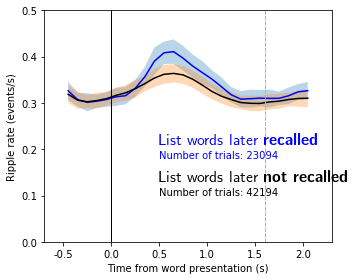

In [6]:
plot_ME_mean = 1 # 0 for typical PSTH, 1 for ME mean, 2 for average across sub averages
save_plot_data = 0

%autoreload
import warnings
# get PSTH for recalled and then forgotten words. 
# Then bin it for the CIs and plot each
# then do ME stats on seleted bins and add significance bars if p<0.05

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700]

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?

desired_sample_rate = 500.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate


if exp == 'RepFR1':
    # *** For RepFR only select your presentation and repeat numbers *** 

    presentation_selection = [2,3] # 1st, 2nd, or 3rd presentation of words? (put in a list like [2] or [2,3])
    repeat_selection = [3] # 1p, 2p, or 3p words? (also in list form)

    selected_idxs = np.intersect1d(findAinB(presentation_selection,presentation_array),
                                   findAinB(repeat_selection,repeat_array))

    start_array = start_array[selected_idxs]
    encoded_word_key_array = encoded_word_key_array[selected_idxs]
    sub_name_array = subject_name_array[selected_idxs]
    sess_name_array = session_name_array[selected_idxs]    


# get vectors of encoding list identifier data for forgotten and recalled words
# in encoded_word_key_array, 0 for not recalled, 1 for recalled, 2 for recalled but was an IRI<2 (don't care about that for encoding)

start_array_enc_forgot = start_array[word_correct_array==0]
start_array_enc_recalled = start_array[word_correct_array==1]

# same for sub and sess
sub_forgot = np.array(subject_name_array)[word_correct_array==0]
sess_forgot = np.array(session_name_array)[word_correct_array==0]
sub_recalled = np.array(subject_name_array)[word_correct_array==1]
sess_recalled = np.array(session_name_array)[word_correct_array==1]


# for recalled and then forgotten words
for category in range(2):
    if category == 0:
        temp_start_array = start_array_enc_recalled
        sub_name_array = sub_recalled
        sess_name_array = sess_recalled
        
        # for plot
        subplots(1,1,figsize=(5,4))
        label = 'List words later \\textbf{recalled}'
        plot_color = (0,0,1)
        text(500,0.21,label,usetex=True,size=16,color=plot_color)
        text(500,0.18,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)

    else:       
        temp_start_array = start_array_enc_forgot
        sub_name_array = sub_forgot
        sess_name_array = sess_forgot
        
        # for plot
        label = 'List words later \\textbf{not recalled}'        
        plot_color = (0,0,0)
        text(500,0.13,label,usetex=True,size=16,color=plot_color) 
        text(500,0.10,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
        
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")    
        mean_plot,SE_plot = getMixedEffectMeanSEs(binned_start_array,sub_name_array,sess_name_array)
    print('SEs created!')
    
    if plot_ME_mean == 1:
        PSTH = triangleSmooth(mean_plot,smoothing_triangle) # replace PSTH with means from ME model (after smoothing as usual)  
    elif plot_ME_mean == 2:
        temp_means = []
        for sub in np.unique(sub_name_array):
            temp_means = superVstack(temp_means,np.mean(binned_start_array[np.array(sub_name_array)==sub],0))
        PSTH = triangleSmooth(np.mean(temp_means,0),smoothing_triangle)
        SE_sub_level = np.std(temp_means,0)/np.sqrt(len(temp_means))    
    
    ## plot ##
    
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    if pad > 0:
        xr = xr[pad:-pad]
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
        PSTH = PSTH[pad:-pad]
        SE_plot = SE_plot[:,pad:-pad]
    
    plot(xr,PSTH,color=plot_color)
    fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
    
    if category == 0:
        PSTH_recalled = copy(PSTH)
        SE_recalled = copy(SE_plot)
    else:
        PSTH_forgotten = copy (PSTH)
        SE_forgotten = copy(SE_plot)

# now that we have the plot with SEs, do stats on key bins. Note here just looking at single bins but comparing across categories
for test in range(2):
    if test == 0:
        first_start = ripple_bin_start_end[0]
        first_end = ripple_bin_start_end[1]
    else:
        first_start = 1700 # same idea but for post-encoding period (ILI)
        first_end = 2300 
        
    bin_test_range = range(int( ((first_start-pre_encoding_time)/sr_factor) ),
                           int( ((first_end-pre_encoding_time)/sr_factor) ))
    binned_recalled_array = start_array_enc_recalled[:,bin_test_range]
    binned_forgot_array = start_array_enc_forgot[:,bin_test_range]
    
    stats_bin = int(first_end-first_start)
    binned_recalled_array = binBinaryArray(binned_recalled_array,stats_bin,sr_factor) # should be creating vectors for both
    binned_forgot_array = binBinaryArray(binned_forgot_array,stats_bin,sr_factor)
    print(np.shape(binned_recalled_array))
    print(np.shape(binned_forgot_array))
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        bin_model = MEstatsAcrossCategories(binned_recalled_array,sub_recalled,sess_recalled,
                                            binned_forgot_array,sub_forgot,sess_forgot)
    
        # plot bands of significance
    if bin_model.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[0.5,0.5],color=(1,0.5,0))
    
    if test == 0:
        bin_model1 = copy(bin_model)
        binned_recalled_array1 = copy(binned_recalled_array)
        binned_forgot_array1 = copy(binned_forgot_array)
    else:
        bin_model2 = copy(bin_model)
        binned_recalled_array2 = copy(binned_recalled_array)
        binned_forgot_array2 = copy(binned_forgot_array)
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))

num_trials = len(word_correct_array) 


# get directories for if you save (don't put this in save_plot_data below since want p-values printed at bottom close to figures)
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
path_name = '/home1/john/SWR/figures/'+subfolder

fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                  '_'+filter_type+'_'+sub_selection+'.p') # -GT_5000.p' # -LT_5000.p' #'-intrusions.p'
print(fn)
print(str(num_trials)+' trials')    
        
if save_plot_data == 1:
    # get strings for path name for save and loading cluster data
            
    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    with open(fn,'wb') as f:
        pickle.dump({'bin_centers':bin_centers,'PSTH_recalled':PSTH_recalled,'PSTH_forgotten':PSTH_forgotten,
                    'SE_recalled':SE_recalled,'SE_forgotten':SE_forgotten,'bin_model1':bin_model1,'bin_model2':bin_model2,
                    'binned_recalled_array1':binned_recalled_array1,'binned_forgot_array1':binned_forgot_array1,
                    'binned_recalled_array2':binned_recalled_array2,'binned_forgot_array2':binned_forgot_array2,
                    'subject_name_array':sub_name_array,'session_name_array':sess_name_array,
                    'electrode_array':electrode_array,'channel_coords_array':channel_coords_array,
                    'word_correct_array':word_correct_array}, f) 
        # word_correct_array is indicator for subsequently remembered and forgotten. Can get num_trials from it too
a=1;

## SME model 100:1700 (also now ANOVA)

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

pre_encoding_time = -700
ripple_bin_start_end = [100,1700] #[400,1100] #[100,1700]
sr_factor = 2
encoding_range = range(int((-pre_encoding_time+ripple_bin_start_end[0])/sr_factor),
                       int((-pre_encoding_time+ripple_bin_start_end[1])/sr_factor)) 
SME_df = pd.DataFrame({'ripple_rate':np.sum(start_array[:,encoding_range],1)/((ripple_bin_start_end[1]-ripple_bin_start_end[0])/1000),
                       'correct':word_correct_array,'session':session_name_array,'subject':subject_name_array})
vc = {'session':'0+session'}
SME_model = smf.mixedlm("ripple_rate ~ correct", SME_df, groups="subject", vc_formula=vc,re_formula="correct")
SME_results = SME_model.fit(reml=True, method='nm',maxiter=2000) 
print(SME_results.summary())
print('**p-values**:'); print(SME_results.pvalues)
print('**coefs**:'); print(SME_results.params)
print('**SEs**:'); print(SME_results.bse_fe)


# R1 asks for simple ANOVA after averaging across patients (we think)

# from statsmodels.formula.api import ols

key = ['subject','correct']
SME_df = SME_df.groupby(key).mean().reset_index() # averages ripple rates for correct and incorrect within each patient
OLS_model = smf.ols("ripple_rate ~ correct", SME_df).fit()
print('Simple ANOVA:')
print(sm.stats.anova_lm(OLS_model))


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   ripple_rate
No. Observations:   65288     Method:               REML       
No. Groups:         56        Scale:                0.2965     
Min. group size:    144       Likelihood:           -53134.2930
Max. group size:    8376      Converged:            Yes        
Mean group size:    1165.9                                     
---------------------------------------------------------------
                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.321    0.019 16.978 0.000  0.284  0.358
correct               0.004    0.009  0.460 0.646 -0.014  0.023
subject Var           0.017    0.007                           
subject x correct Cov 0.001    0.003                           
correct Var           0.003    0.002                           
session Var           0.003    0.001                 

In [8]:
SME_df

,subject,correct,ripple_rate
0,R1024E,0.0,0.361635
1,R1024E,1.0,0.367908
2,R1032D,0.0,0.241636
3,R1032D,1.0,0.136529
4,R1045E,0.0,0.207750
...,...,...,...
107,R1515T,1.0,0.425549
108,R1518T,0.0,0.405882
109,R1518T,1.0,0.360206
110,R1525J,0.0,0.421707


## SME model (400:1100)

In [111]:
# SME model

import statsmodels.api as sm
import statsmodels.formula.api as smf

pre_encoding_time = -700
ripple_bin_start_end = [400,1100]
sr_factor = 2
encoding_range = range(int((-pre_encoding_time+ripple_bin_start_end[0])/sr_factor),
                       int((-pre_encoding_time+ripple_bin_start_end[1])/sr_factor)) 
SME_df = pd.DataFrame({'ripple_rate':np.sum(start_array[:,encoding_range],1)/((ripple_bin_start_end[1]-ripple_bin_start_end[0])/1000),
                       'correct':word_correct_array,'session':session_name_array,'subject':subject_name_array})
vc = {'session':'0+session'}
SME_model = smf.mixedlm("ripple_rate ~ correct", SME_df, groups="subject", vc_formula=vc,re_formula="correct")
SME_results = SME_model.fit(reml=True, method='nm',maxiter=2000) 
print(SME_results.summary())
print('**p-values**:'); print(SME_results.pvalues)
print('**coefs**:'); print(SME_results.params)
print('**SEs**:'); print(SME_results.bse_fe)


             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   ripple_rate
No. Observations:   42519     Method:               REML       
No. Groups:         50        Scale:                0.3714     
Min. group size:    144       Likelihood:           -39391.1920
Max. group size:    2304      Converged:            Yes        
Mean group size:    850.4                                      
---------------------------------------------------------------
                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.206    0.013 15.666 0.000  0.180  0.232
correct               0.006    0.008  0.750 0.453 -0.010  0.023
subject Var           0.006    0.003                           
subject x correct Cov 0.000    0.001                           
correct Var           0.001    0.001                           
session Var           0.003    0.001                 

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## rise in ripples stats

In [112]:
# R1 asks to measure the rise in ripples after word presentation...take first 800 vs. next 800 ms

baseline_length = 800 # this takes -700 to 100 ms aligned to word_on
ripple_bin_start_end = [100,900] # only need to do this for word presentation period
encoding_range = range(int((-pre_encoding_time+ripple_bin_start_end[0])/sr_factor),
                       int((-pre_encoding_time+ripple_bin_start_end[1])/sr_factor)) 
pre_stim_range = range(0, int(baseline_length/sr_factor))
encoding_df = pd.DataFrame({'ripple_rate':np.sum(start_array[:,encoding_range],1)/((ripple_bin_start_end[1]-ripple_bin_start_end[0])/1000),
                       'session':session_name_array,'subject':subject_name_array,'post_stim':np.ones(len(session_name_array))})
pre_stim_df = pd.DataFrame({'ripple_rate':np.sum(start_array[:,pre_stim_range],1)/(baseline_length/1000),
                       'session':session_name_array,'subject':subject_name_array,'post_stim':np.zeros(len(session_name_array))})
encoding_df = encoding_df.append(pre_stim_df)
encoding_df = encoding_df.reset_index()
post_stim_model = smf.mixedlm("ripple_rate ~ post_stim", encoding_df, groups="subject", vc_formula=vc,re_formula="post_stim")
post_stim_results = post_stim_model.fit(reml=True, method='nm',maxiter=2000) 
print(post_stim_results.summary())
print('**p-values**:'); print(post_stim_results.pvalues)
print('**coefs**:'); print(post_stim_results.params)
print('**SEs**:'); print(post_stim_results.bse_fe)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    ripple_rate
No. Observations:    85038      Method:                REML       
No. Groups:          50         Scale:                 0.3246     
Min. group size:     288        Likelihood:            -72982.8909
Max. group size:     4608       Converged:             Yes        
Mean group size:     1700.8                                       
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.196    0.011 17.270 0.000  0.174  0.218
post_stim                0.009    0.007  1.261 0.207 -0.005  0.022
subject Var              0.005    0.003                           
subject x post_stim Cov -0.000    0.001                           
post_stim Var            0.001    0.001                           
session Va

## just to remake plot

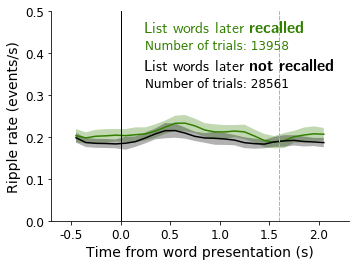

In [113]:
save_plot = 0

subplots(1,1,figsize=(5,3.75))

# for recalled and then forgotten words
for category in range(2):
    if category == 0:
        temp_start_array = start_array_enc_recalled
        sub_name_array = sub_recalled
        sess_name_array = sess_recalled
        
        # for plot
        label = 'List words later \\textbf{recalled}'
        ytextshift = 0
        if location_selected == 'ca1':
            plot_color = (0,0,1)
            ytextshift = 0
        elif location_selected == 'dg':
            plot_color = (1,0,0)
            ytextshift = 0
        elif region_name == 'ENT':
            plot_color = (0.5,0.5,0)
            ytextshift = -0.3
        elif region_name == 'PHC':
            plot_color = (0,0.5,0.5)
            ytextshift = 0.05
        elif region_name == 'AMY':
            plot_color = (0.2,0.5,0)
            ytextshift = -0.25
        elif region_name == 'ENTPHC':
            plot_color = (0.5,0.2,0)
            ytextshift = -0.25           
        text(250,0.2-ytextshift,label,usetex=True,size=16,color=plot_color)
        text(250,0.16-ytextshift,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
        
        PSTH = copy(PSTH_recalled)
        SE_plot = copy(SE_recalled)

    else:       
        temp_start_array = start_array_enc_forgot
        sub_name_array = sub_forgot
        sess_name_array = sess_forgot
        
        # for plot
        label = 'List words later \\textbf{not recalled}'        
        plot_color = (0,0,0)
        text(250,0.11-ytextshift,label,usetex=True,size=16,color=plot_color) 
        text(250,0.07-ytextshift,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
        
        PSTH = copy(PSTH_forgotten)
        SE_plot = copy(SE_forgotten)
        
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    PSTH = PSTH; #boot_SD = boot_SD[pad:-pad]
    plot(xr,PSTH,color=plot_color)
    fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], facecolor=plot_color, alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)',fontsize=14)
    ylabel('Ripple rate (events/s)',fontsize=14)
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
    tight_layout()

xticks(fontsize=12)
yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)  
    

if save_plot == 1:
    
    path_name = '/home1/john/SWR/figures/ENCODING/'
    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+'_'+soz_label+\
                      '_'+filter_type+'_'+sub_selection+'_'+str(plot_ME_mean)+'.pdf') # -GT_5000.p' # -LT_5000.p' #'-intrusions.p'
    plt.savefig(fn,transparent=True)
a=1;

# encoding ripples by serial position

In [149]:
## plot recalled events by serial position

bin_size = 100 # in ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700]
sr_factor = 2 # since set ripples to 500 Hz resolution
first_start = int(ripple_bin_start_end[0]/bin_size)
first_end = int(ripple_bin_start_end[1]/bin_size)
bin_test_range = range(int( ((first_start-pre_encoding_time/bin_size)) ),
                       int( ((first_end-pre_encoding_time/bin_size)) )) # already accounted for sr_factor to get to 100 ms bin temp_array

ct = 0
serial_position_rem_rates = []
serial_position_rem_stds = []
serial_position_forgot_rates = []
serial_position_forgot_stds = []
num_recalled = []; num_forgot = []

for list_num in range(12):
    
    temp_start_array_rem = start_array[(word_correct_array==1) & (serialpos_array==(list_num+1))]
    temp_start_array_forgot = start_array[(word_correct_array==0) & (serialpos_array==(list_num+1))]

    temp_array_rem = binBinaryArray(temp_start_array_rem,bin_size,sr_factor)
    temp_array_forgot = binBinaryArray(temp_start_array_forgot,bin_size,sr_factor)

    # save data for full serial position plot below
    serial_position_rem_rates.append(np.mean(temp_array_rem[:,bin_test_range]))
    serial_position_rem_stds.append(np.std(temp_array_rem[:,bin_test_range])/np.sqrt(len(temp_array_rem)))
    serial_position_forgot_rates.append(np.mean(temp_array_forgot[:,bin_test_range]))
    serial_position_forgot_stds.append(np.std(temp_array_forgot[:,bin_test_range])/np.sqrt(len(temp_array_forgot)))
    num_recalled.append(temp_array_rem.shape[0])
    num_forgot.append(temp_array_forgot.shape[0])   
a=1;

Number in each bin: 3192


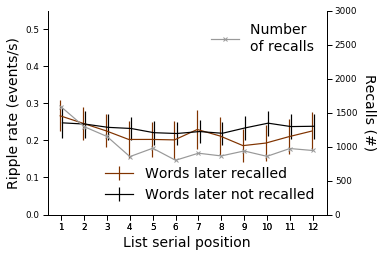

In [150]:
# create the general figure
fig1 = figure(figsize=(5,3.75))
 
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)

xr=np.arange(1,13)

if location_selected == 'ca1':
    plot_color = (0,0,1)
elif location_selected == 'dg':
    plot_color = (1,0,0)
elif region_name == 'AMY':
    plot_color = (0.2,0.5,0)
elif region_name == 'ENTPHC':
    plot_color = (0.5,0.2,0)

line1 = errorbar(xr-0.05,serial_position_rem_rates,serial_position_rem_stds,color=plot_color) 
line2 = errorbar(xr+0.05,serial_position_forgot_rates,serial_position_forgot_stds,color=(0,0,0))
xticks(xr,xr)
ax1.set_ylim(0,0.55)
xlabel('List serial position',size=14)
ylabel('Ripple rate (events/s)',size=14)
# if bin_range_to_compare == range(10,20):
#     title('Ripple rate 100-1700 ms after word presentation')
# elif bin_range_to_compare == range(24,29): 
#     title('Ripple rate 1700-2200 ms after word presentation')
    
# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line3 = ax2.plot(xr,num_recalled, 'xr-',color=(0.6,0.6,0.6))
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
if location_selected == 'ca1':
    ax2.set_ylim(0,7950) #2500)
elif location_selected == 'dg':
    ax2.set_ylim(0,5400)  
else:
    ax2.set_ylim(0,3000)
ylabel("Recalls (#)",rotation=270,size=14)
ax2.yaxis.set_label_coords(1.18,0.5)

ax1.legend((line1,line2),("Words later recalled","Words later not recalled"),frameon=False,fontsize=14,loc='lower right')
if (exp == 'catFR1'):
    ax2.legend(line3,{"Number \nof recalls"},loc='upper right',frameon=False,fontsize=14)
else:
    ax2.legend(line3,{"Number of recalls"},loc='upper right',frameon=False,fontsize=14)    

# for the legend, remember that we used two different axes so, we need 
# to build the legend manually
# legend((line1, line2), ("1", "2"))
ax1.spines['top'].set_visible(False)   
print('Number in each bin: '+str(len(temp_array_rem)+len(temp_array_forgot)))
show();

# ripple SME serialpos by list

Number in each bin: 2530


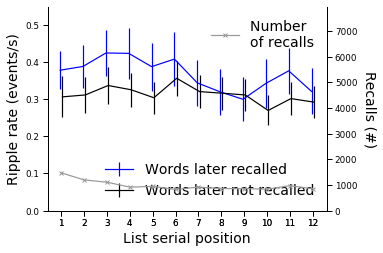

Number in each bin: 2473


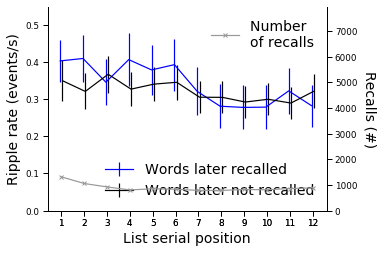

Number in each bin: 1531


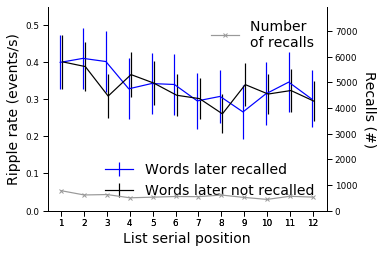

Number in each bin: 931


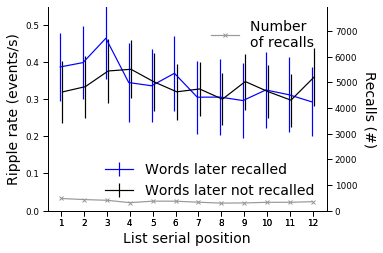

Number in each bin: 836


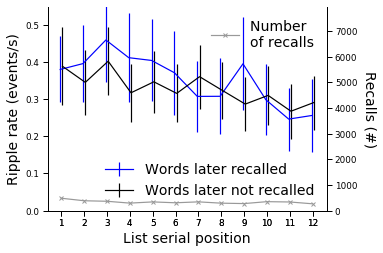

In [140]:
bin_by = 5

## plot recalled events by serial position

bin_size = 100 # in ms
pre_encoding_time = -700
ripple_bin_start_end = [100,1700]
sr_factor = 2 # since set ripples to 500 Hz resolution
first_start = int(ripple_bin_start_end[0]/bin_size)
first_end = int(ripple_bin_start_end[1]/bin_size)
bin_test_range = range(int( ((first_start-pre_encoding_time/bin_size)) ),
                       int( ((first_end-pre_encoding_time/bin_size)) )) # already accounted for sr_factor to get to 100 ms bin temp_array

for list_bin in np.arange(1,6):
    ct = 0
    serial_position_rem_rates = []
    serial_position_rem_stds = []
    serial_position_forgot_rates = []
    serial_position_forgot_stds = []
    num_recalled = []; num_forgot = []
    
    for list_num in range(12):
    
        temp_start_array_rem = start_array[(word_correct_array==1) & (serialpos_array==(list_num+1)) & \
                                    [ll in np.arange((list_bin-1)*bin_by+1,list_bin*bin_by+1) for ll in list_num_key]]
        temp_start_array_forgot = start_array[(word_correct_array==0) & (serialpos_array==(list_num+1)) & \
                                    [ll in np.arange((list_bin-1)*bin_by+1,list_bin*bin_by+1) for ll in list_num_key]]

        temp_array_rem = binBinaryArray(temp_start_array_rem,bin_size,sr_factor)
        temp_array_forgot = binBinaryArray(temp_start_array_forgot,bin_size,sr_factor)

        # save data for full serial position plot below
        serial_position_rem_rates.append(np.mean(temp_array_rem[:,bin_test_range]))
        serial_position_rem_stds.append(np.std(temp_array_rem[:,bin_test_range])/np.sqrt(len(temp_array_rem)))
        serial_position_forgot_rates.append(np.mean(temp_array_forgot[:,bin_test_range]))
        serial_position_forgot_stds.append(np.std(temp_array_forgot[:,bin_test_range])/np.sqrt(len(temp_array_forgot)))
        num_recalled.append(temp_array_rem.shape[0])
        num_forgot.append(temp_array_forgot.shape[0])

    # create the general figure
    fig1 = figure(figsize=(5,3.75))

    # and the first axes using subplot populated with data 
    ax1 = fig1.add_subplot(111)

    xr=np.arange(1,13)

    if location_selected == 'ca1':
        plot_color = (0,0,1)
    elif location_selected == 'dg':
        plot_color = (1,0,0)
    elif region_name == 'AMY':
        plot_color = (0.2,0.5,0)
    elif region_name == 'ENTPHC':
        plot_color = (0.5,0.2,0)

    line1 = errorbar(xr-0.05,serial_position_rem_rates,serial_position_rem_stds,color=plot_color) 
    line2 = errorbar(xr+0.05,serial_position_forgot_rates,serial_position_forgot_stds,color=(0,0,0))
    xticks(xr,xr)
    ax1.set_ylim(0,0.55)
    xlabel('List serial position',size=14)
    ylabel('Ripple rate (events/s)',size=14)
    # if bin_range_to_compare == range(10,20):
    #     title('Ripple rate 100-1700 ms after word presentation')
    # elif bin_range_to_compare == range(24,29): 
    #     title('Ripple rate 1700-2200 ms after word presentation')

    # now, the second axes that shares the x-axis with the ax1
    ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
    line3 = ax2.plot(xr,num_recalled, 'xr-',color=(0.6,0.6,0.6))
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    if location_selected == 'ca1':
        ax2.set_ylim(0,7950) #2500)
    elif location_selected == 'dg':
        ax2.set_ylim(0,5400)    
    ylabel("Recalls (#)",rotation=270,size=14)
    ax2.yaxis.set_label_coords(1.18,0.5)

    ax1.legend((line1,line2),("Words later recalled","Words later not recalled"),frameon=False,fontsize=14,loc='lower right')
    if (exp == 'catFR1'):
        ax2.legend(line3,{"Number \nof recalls"},loc='upper right',frameon=False,fontsize=14)
    else:
        ax2.legend(line3,{"Number of recalls"},loc='upper right',frameon=False,fontsize=14)    

    # for the legend, remember that we used two different axes so, we need 
    # to build the legend manually
    # legend((line1, line2), ("1", "2"))
    ax1.spines['top'].set_visible(False)   
    print('Number in each bin: '+str(len(temp_array_rem)+len(temp_array_forgot)))
    show()   
a=1;

In [134]:
np.shape(temp_array_rem)

(6070, 30)